In [1]:
!nvidia-smi

Fri Feb 26 22:56:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%cd /content

/content


In [3]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-02-26 22:57:00--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  44.1MB/s    in 6.7s    

2021-02-26 22:57:07 (35.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
!unzip -q tiny-imagenet-200.zip

In [5]:
%pip install -q tensorflow-addons[tensorflow]
%pip install -q wandb

     |████████████████████████████████| 706kB 6.9MB/s 
     |████████████████████████████████| 2.0MB 5.4MB/s 
     |████████████████████████████████| 102kB 9.1MB/s 
     |████████████████████████████████| 133kB 23.2MB/s 
     |████████████████████████████████| 163kB 24.3MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 


In [6]:
!git clone https://github.com/ShivamShrirao/tiny-imagenet-test

Cloning into 'tiny-imagenet-test'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 30 (delta 11), reused 24 (delta 5), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [7]:
%cd tiny-imagenet-test

/content/tiny-imagenet-test


In [ ]:
!git pull

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import glob
import os
import csv
from tqdm.notebook import tqdm
from time import time
import random
%matplotlib inline

In [10]:
import tensorflow_addons as tfa

In [11]:
import wandb
from wandb.keras import WandbCallback

In [12]:
tf.keras.backend.set_image_data_format('channels_first')

In [13]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [14]:
import preprocessing

In [15]:
preprocessing.img_height, preprocessing.img_width = 64, 64
preprocessing.BATCH_SIZE = 512

In [16]:
# MOVE DATA LOADING TO FILES

In [17]:
TRAIN_PATH = "../tiny-imagenet-200/train/"
TEST_PATH = "../tiny-imagenet-200/test/"
VAL_PATH = "../tiny-imagenet-200/val/"

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

In [19]:
preprocessing.class_names = np.array(sorted([fp.split('/')[-1] for fp in glob.glob(TRAIN_PATH+"*")]))

In [20]:
preprocessing.val_labels = {}
with open(VAL_PATH+"val_annotations.txt") as fIn:
    reader = csv.reader(fIn, delimiter='\t')
    for row in reader:
        preprocessing.val_labels[row[0]] = row[1]

In [21]:
train_list_ds = (
    tf.data.Dataset.list_files(TRAIN_PATH+"*/images/*", shuffle=True)
    .map(preprocessing.process_train_path, num_parallel_calls=AUTOTUNE)
    .cache()
)

In [22]:
val_list_ds = (
    tf.data.Dataset.list_files(VAL_PATH+"images/*")
    .map(preprocessing.process_val_path, num_parallel_calls=AUTOTUNE)
    .cache()
)

In [23]:
mean = []
std = []
for a,b in train_list_ds.take(1024):
    mean.append(a.numpy())
    std.append(a.numpy())
mean = np.asarray(mean).mean(axis=(0,1,2)).reshape(1,3,1,1)
std = np.asarray(std).std(axis=(0,1,2)).reshape(1,3,1,1)

In [24]:
mean.ravel(), std.ravel()

(array([0.470968  , 0.44205904, 0.38082787], dtype=float32),
 array([0.27687606, 0.26806986, 0.27593207], dtype=float32))

In [25]:
mean = tf.convert_to_tensor(mean)
std = tf.convert_to_tensor(std)

In [26]:
augmentation_layers = preprocessing.get_augmentation_layers()
def augmentation_layers_wrapper(x, y):
    with tf.device('/device:GPU:0'):
        return augmentation_layers(x, training=True), y

In [27]:
train_ds = (
    train_list_ds
    .batch(preprocessing.BATCH_SIZE)
    .map(preprocessing.augment_wrapper, num_parallel_calls=AUTOTUNE)
    .map(augmentation_layers_wrapper, num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: preprocessing.channel_first_and_normalize(x, y, mean, std), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [28]:
val_ds = (
    val_list_ds
    .batch(preprocessing.BATCH_SIZE)
    .map(lambda x, y: preprocessing.channel_first_and_normalize(x, y, mean, std), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [29]:
a, b = next(iter(train_ds))
a.shape

TensorShape([512, 3, 64, 64])

In [30]:
idx = np.random.randint(0,128)
x = a.numpy()[idx]
z = (x-x.min())/(x.max()-x.min())
z = z.transpose(1,2,0)
preprocessing.class_names[b[idx]]

'n02094433'

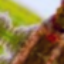

In [31]:
PIL.Image.fromarray((z*255).astype(np.uint8))

In [32]:
class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [33]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [34]:
config_defaults = {
    'activation'            : 'relu',
    'dp_rate'               : 0.25,
    'batch_size'            : preprocessing.BATCH_SIZE,
    'norm'                  : 'bn',
    'self_attn'             : True,
    'frac_dk'               : 0.5,
    'frac_dv'               : 0.25,
    'pos_emb'               : True,
    'optimizer'             : 'adamw',
    'lr_type'               : 'clr',
    'min_lr'                : 1e-4,
    'max_lr'                : 1e-3,
    'weight_decay'          : 2e-5,     #maximum
    'vary_weight_decay'     : True,
    'clr_step_size'         : 8,
    'loss_function'         : 'cce',
}

In [35]:
run = wandb.init(project="tiny-imagenet-test", entity="shivamshrirao", config=config_defaults)
CONFIG = wandb.config

wandb: Currently logged in as: shivamshrirao (use `wandb login --relogin` to force relogin)


In [36]:
# CONFIG = AttributeDict(config_defaults)

In [37]:
import conv_utils

In [38]:
conv_utils.CONFIG = CONFIG

In [44]:
inp = layers.Input(shape=(3,preprocessing.img_height, preprocessing.img_width))

In [45]:
x = conv_utils.conv_norm(inp, 16, kernel_size=5, strides=1, activation=CONFIG.activation)
x = conv_utils.conv_norm(x, 64, kernel_size=3, strides=2, activation=CONFIG.activation,
                    do_norm_act=False)

In [46]:
x = conv_utils.down_stack(x, fltrs=[16, 32, 32], self_attn=False, dp_rate=CONFIG.dp_rate)   # (128, 16, 16)
x = conv_utils.down_stack(x, fltrs=[32, 64, 64], self_attn=[False, True, True], dp_rate=CONFIG.dp_rate)   # (256, 8, 8)
x = conv_utils.down_stack(x, fltrs=[64,128,128], self_attn=True, dp_rate=CONFIG.dp_rate)   # (512, 4, 4)

In [47]:
x = conv_utils.conv_norm(x, 1024, kernel_size=3, strides=1, activation=CONFIG.activation)
x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
if CONFIG.dp_rate:
    x = layers.Dropout(CONFIG.dp_rate)(x)
x = layers.Dense(len(preprocessing.class_names))(x)
x = layers.Softmax(axis=1)(x)

In [48]:
model = tf.keras.Model(inputs=inp, outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3, 64, 64)]  0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 16, 64, 64)   1216        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 16, 64, 64)   64          conv2d_46[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 16, 64, 64)   0           batch_normalization_29[0][0]     
____________________________________________________________________________________________

In [49]:
model_plot = tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, dpi=None)

In [50]:
wandb.log({"model": wandb.Image("model.png")})

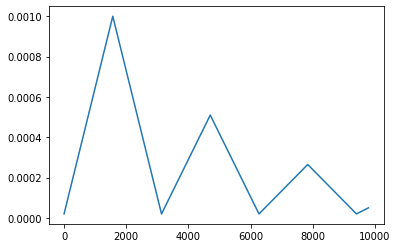

In [51]:
steps_per_epoch = len(train_ds)
clr = tfa.optimizers.Triangular2CyclicalLearningRate(
            initial_learning_rate=CONFIG.min_lr,
            maximal_learning_rate=CONFIG.max_lr,
            step_size=CONFIG.clr_step_size * steps_per_epoch,
            scale_mode="cycle")
domain = range(0, 50*steps_per_epoch, 32)
lr_log = [clr(i).numpy() for i in domain]
plt.plot(domain, lr_log)
plt.show()

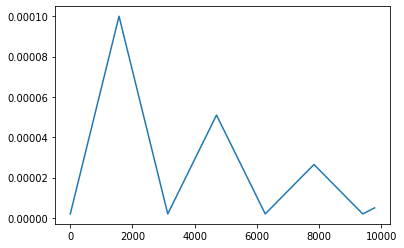

In [53]:
def get_wdc(i):
    wdc = CONFIG.weight_decay*clr(i)/CONFIG.max_lr
    if tf.executing_eagerly():
        return wdc.numpy()
    else:
        return wdc
wdc_log = [get_wdc(i) for i in domain]
plt.plot(domain, wdc_log)
plt.show()

In [54]:
if CONFIG.optimizer == 'adamw':
    opt = tfa.optimizers.AdamW(learning_rate=clr, weight_decay=lambda : CONFIG.weight_decay)
    # wd_schedule = tf.optimizers.schedules.ExponentialDecay(5e-5, 100, 0.9)    # weight_decay=lambda : None
    if CONFIG.vary_weight_decay:
        opt.weight_decay = lambda : get_wdc(opt.iterations)
elif CONFIG.optimizer == 'adam':            # or just make weight_decay=0
    opt = tf.keras.optimizers.Adam(learning_rate=clr)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [55]:
if CONFIG.loss_function == 'cce':
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

In [56]:
model.compile(optimizer=opt, loss=loss_function, metrics=['accuracy'])

In [57]:
wandb_cb = WandbCallback(monitor='val_accuracy', mode='max', generator=val_ds)

In [ ]:
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[wandb_cb])

Epoch 1/50
196/196 [==============================] - 210s 958ms/step - loss: 5.2929 - accuracy: 0.0121 - val_loss: 5.4149 - val_accuracy: 0.0108
Epoch 2/50
196/196 [==============================] - 117s 592ms/step - loss: 4.9001 - accuracy: 0.0356 - val_loss: 5.0242 - val_accuracy: 0.0389
Epoch 3/50
196/196 [==============================] - 117s 589ms/step - loss: 4.7150 - accuracy: 0.0529 - val_loss: 5.5271 - val_accuracy: 0.0367
Epoch 4/50
196/196 [==============================] - 116s 588ms/step - loss: 4.5367 - accuracy: 0.0723 - val_loss: 5.7416 - val_accuracy: 0.0393
Epoch 5/50
196/196 [==============================] - 115s 581ms/step - loss: 4.3558 - accuracy: 0.0947 - val_loss: 5.7707 - val_accuracy: 0.0405
Epoch 6/50
196/196 [==============================] - 116s 585ms/step - loss: 4.1674 - accuracy: 0.1204 - val_loss: 4.7526 - val_accuracy: 0.0796
Epoch 7/50
196/196 [==============================] - 116s 588ms/step - loss: 4.0031 - accuracy: 0.1428 - val_loss: 5.0710 -